In [51]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [52]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

#### RNN: Formula Label Prediction 

In [53]:
import numpy as np 
import pandas as pd
from pathlib import Path 

import tensorflow as tf

from tensorflow.keras import layers 
from tensorflow.keras import utils

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import datetime

tfds.disable_progress_bar()

In [54]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [55]:
def preprocess_data(wp_tokenizer, corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        # put in tokenization
        result = wp_tokenizer.tokenize(f_list)
        #print(result.to_list())
        try:
            token_list = [n_tk[0].decode("ASCII") for n_tk in result.to_list() if not n_tk == []]
            token_list = [n_tk for n_tk in token_list if not n_tk == "[UNK]"]
            token_list = wp_tokenizer.tokenize(f_list)
        except Exception as e:
            print(e)
        cell_str = " ".join(f_list)
        return cell_str

    corpus["tokens"] = corpus["tokens"].map(process_cell)

In [56]:
# wordpiece subword tokenization with a lookuptable interface

def _CreateTable(vocab, num_oov=1):
  init = tf.lookup.KeyValueTensorInitializer(
      vocab,
      tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64),
      key_dtype=tf.string,
      value_dtype=tf.int64)
  return tf.lookup.StaticVocabularyTable(
      init, num_oov, lookup_key_dtype=tf.string)

vocab_list = [  '', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':', \
                '-', '\\to', '=', '3', 'g', 'n', 'a', 'A', '0', '4', '\\frac', 'b', \
                'B', '\\rightarrow', 'X', '5', 'y', '\\mathbb{R}', '\\mathbb{N}',   \
                '\\mathbb', 'Y', '6', 'h', 'R', 'c', '/', '7', '\\colon', '9', 'p', \
                'k', 't', 'F', '8', 'm', 'i', 'S', 'd', 'e', 'N', '\\times', 'z', \
                's', 'C', 'q', 'r', ']', '\\circ', '[', '\\mathbb{Z}', '\\dfrac', \
                '\\mathbb{Q}', '\\cdot', '\\sin', '\\cup', 'T', 'u', 'Z', 'P', '!', \
                'M', '\\cap', 'G', 'E', 'D', 'U', 'Q', 'I', 'v', 'w', 'j', 'H', \
                '*', '\\varnothing', 'V', '\\cos', 'W', '\\exp', 'o', '\\arcsin', \
                '\\binom', 'l', '\\mathbb{C}', 'K', '\\ln', 'J', '\\arctan', 'L', \
                '\\cot', '\\cosh', 'O', '\\tanh', '\\arccos', '\\tfrac', '\\log', \
                '\\div', '\\sinh', '\\dbinom']
vocab_table = _CreateTable(vocab_list)
wp_tokenizer = tf_text.WordpieceTokenizer(
        vocab_table, token_out_type=str)

In [57]:
tokens =["[", "a", "ab}"]
result = wp_tokenizer.tokenize(tokens)
print(result.to_list())

[[b'['], [b'a'], [b'[UNK]']]


In [58]:
data_p = Path("data/") / "bin_class_data_TOKENIZED_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(wp_tokenizer, data)
data.head()


,tokens,label
0,{ a },1
1,3 r,1
2,f,1
3,\binom { 4 } { 4 },1
4,1,1


In [59]:
DATASET_SIZE = 11000
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"], data["label"])) 
test_dataset = data_as_ds.take(1000)
train_dataset = data_as_ds.skip(1000)

##### Setup and Data Preparation

In [60]:
for example, label in train_dataset.take(1):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

text:  b'g ( x ) = x ^ 2 + 2 x'
label:  1


In [61]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [62]:
def create_encoder(output_mode_str, n_grams):
    VOCAB_SIZE = 1000
    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        split="whitespace",
        max_tokens=VOCAB_SIZE)
    encoder.adapt(train_dataset.map(lambda tokens, label: tokens)) # removes the label column through transformation: text, label -> text
    return encoder

##### Representation 1: Use integer indices encoding

In [63]:
encoder_int = create_encoder("int", None)
vocab = np.array(encoder_int.get_vocabulary())
vocab[:200]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


array(['', '[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '\\to', '=', '3', 'g', 'n', 'a', 'A', '0', '4', '\\frac', 'b',
       'B', '\\rightarrow', 'X', '5', 'y', '\\mathbb{R}', '\\mathbb{N}',
       '\\mathbb', 'Y', '6', 'h', 'R', 'c', '/', '7', '\\colon', '9', 'p',
       'k', 't', 'F', '8', 'm', 'i', 'S', 'd', 'e', 'N', '\\times', 'z',
       's', 'C', 'q', 'r', ']', '\\circ', '[', '\\mathbb{Z}', '\\dfrac',
       '\\mathbb{Q}', '\\cdot', '\\sin', '\\cup', 'T', 'u', 'Z', 'P', '!',
       'M', '\\cap', 'G', 'E', 'D', 'U', 'Q', 'I', 'v', 'w', 'j', 'H',
       '*', '\\varnothing', 'V', '\\cos', 'W', '\\exp', 'o', '\\arcsin',
       '\\binom', 'l', '\\mathbb{C}', 'K', '\\ln', 'J', '\\arctan', 'L',
       '\\cot', '\\cosh', 'O', '\\tanh', '\\arccos', '\\tfrac', '\\log',
       '\\div', '\\sinh', '\\dbinom'], dtype='<U11')

In [64]:
encoded_example = encoder_int(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[17  8  3  9 15  3 10  5 11  5  3]


In [65]:
print("Original: ", example.numpy())
print("After reverse lookup: ", " ".join(vocab[encoded_example]))

Original:  b'g ( x ) = x ^ 2 + 2 x'
After reverse lookup:  g ( x ) = x ^ 2 + 2 x


##### Representation 2: Binary Count Vectorizer

In [66]:
encoder_multi_hot = create_encoder("multi_hot", None)
vocab = np.array(encoder_multi_hot.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '\\to', '=', '3', 'g', 'n', 'a', 'A', '0', '4', '\\frac', 'b',
       'B', '\\rightarrow', 'X', '5', 'y', '\\mathbb{R}', '\\mathbb{N}',
       '\\mathbb', 'Y', '6', 'h', 'R', 'c', '/', '7', '\\colon', '9', 'p',
       'k', 't', 'F', '8', 'm', 'i', 'S', 'd', 'e', 'N', '\\times', 'z',
       's', 'C', 'q', 'r', ']', '\\circ', '[', '\\mathbb{Z}', '\\dfrac',
       '\\mathbb{Q}', '\\cdot', '\\sin', '\\cup', 'T', 'u', 'Z', 'P', '!',
       'M', '\\cap', 'G', 'E', 'D', 'U', 'Q', 'I', 'v', 'w', 'j', 'H',
       '*', '\\varnothing', 'V', '\\cos', 'W', '\\exp', 'o', '\\arcsin',
       '\\binom', 'l', '\\mathbb{C}', 'K', '\\ln', 'J', '\\arctan', 'L',
       '\\cot', '\\cosh', 'O', '\\tanh', '\\arccos', '\\tfrac', '\\log',
       '\\div', '\\sinh', '\\dbinom'], dtype='<U11')

In [67]:
encoded_example = encoder_multi_hot(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##### Representation 3: Frequency Count Vectorizer

In [68]:
encoder_count = create_encoder("count", None)
vocab = np.array(encoder_count.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '\\to', '=', '3', 'g', 'n', 'a', 'A', '0', '4', '\\frac', 'b',
       'B', '\\rightarrow', 'X', '5', 'y', '\\mathbb{R}', '\\mathbb{N}',
       '\\mathbb', 'Y', '6', 'h', 'R', 'c', '/', '7', '\\colon', '9', 'p',
       'k', 't', 'F', '8', 'm', 'i', 'S', 'd', 'e', 'N', '\\times', 'z',
       's', 'C', 'q', 'r', ']', '\\circ', '[', '\\mathbb{Z}', '\\dfrac',
       '\\mathbb{Q}', '\\cdot', '\\sin', '\\cup', 'T', 'u', 'Z', 'P', '!',
       'M', '\\cap', 'G', 'E', 'D', 'U', 'Q', 'I', 'v', 'w', 'j', 'H',
       '*', '\\varnothing', 'V', '\\cos', 'W', '\\exp', 'o', '\\arcsin',
       '\\binom', 'l', '\\mathbb{C}', 'K', '\\ln', 'J', '\\arctan', 'L',
       '\\cot', '\\cosh', 'O', '\\tanh', '\\arccos', '\\tfrac', '\\log',
       '\\div', '\\sinh', '\\dbinom'], dtype='<U11')

In [69]:
encoded_example = encoder_count(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[0. 0. 3. 0. 2. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##### Representation 4: Bigrams Frequency Count Vectorizer

In [70]:
encoder_bigrams = create_encoder("count", (2))
vocab = np.array(encoder_bigrams.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '( x', '\\to', '=', ') =', 'x )', 'f (', 'f :', '3', '^ 2',
       'g', 'n', 'a', 'A', '} {', '0', '4', 'x ^', '\\frac {', '\\frac',
       'b', 'B', '1 }', '\\rightarrow', 'X', '5', '^ {', 'y', '+ 1',
       '- 1', '{ 1', '\\mathbb{R}', 'x +', '\\mathbb{N}', '\\mathbb',
       ': A', '2 }', '2 +', '{ x', 'Y', '6', '= x', 'h', 'x -', '{ 2',
       'R', 'c', '/', 'A \\to', '1 )', ': X', '7', '\\colon', '9', 'p',
       '\\to B', 'k', '( n', '2 ^', 'X \\to', 'g :', 'x }', 't',
       '\\mathbb R', '^ 3', 'n +', 'F', '8', '{ a', 'a b', '= \\frac',
       '- 2', 'm', '3 }', 'i', '2 -', '\\to Y', '+ b', '- x', 'S', '+ 2',
       ') ^', '2 x', 'd', 'f \\colon', 'e', 'N', '\\times',
       ': \\mathbb{R}', 'n )', 'g (', '\\to \\mathbb{R}', ': \\mathbb{N}',
       '^ x', '0 1', 'z', 'a ^', '^ n', 'A \\rightarrow', 's', '1 /',
       ') (', 'C', 'x y', 'b }', '\\mathbb{N} \\to', 'a +', ': \\mathbb',
       '( a',

In [71]:
encoded_example = encoder_bigrams(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[0. 0. 3. 0. 2. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

##### Representation 5: Tf-Idf Vectorizer

In [72]:
encoder_tf_idf = create_encoder("tf_idf", None)
vocab = np.array(encoder_tf_idf.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '\\to', '=', '3', 'g', 'n', 'a', 'A', '0', '4', '\\frac', 'b',
       'B', '\\rightarrow', 'X', '5', 'y', '\\mathbb{R}', '\\mathbb{N}',
       '\\mathbb', 'Y', '6', 'h', 'R', 'c', '/', '7', '\\colon', '9', 'p',
       'k', 't', 'F', '8', 'm', 'i', 'S', 'd', 'e', 'N', '\\times', 'z',
       's', 'C', 'q', 'r', ']', '\\circ', '[', '\\mathbb{Z}', '\\dfrac',
       '\\mathbb{Q}', '\\cdot', '\\sin', '\\cup', 'T', 'u', 'Z', 'P', '!',
       'M', '\\cap', 'G', 'E', 'D', 'U', 'Q', 'I', 'v', 'w', 'j', 'H',
       '*', '\\varnothing', 'V', '\\cos', 'W', '\\exp', 'o', '\\arcsin',
       '\\binom', 'l', '\\mathbb{C}', 'K', '\\ln', 'J', '\\arctan', 'L',
       '\\cot', '\\cosh', 'O', '\\tanh', '\\arccos', '\\tfrac', '\\log',
       '\\div', '\\sinh', '\\dbinom'], dtype='<U11')

In [73]:
encoded_example = encoder_tf_idf(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[0.        0.        6.629644  0.        4.0315437 0.        0.
 2.1011312 2.1011312 2.2178829 2.4974902 0.        0.        0.
 2.5330882 0.        2.7413087 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0. 

##### Model (Bidirectional LSTM with one layer)

 **Define and compile model**

In [74]:
def create_model(vec_encoder):
    model = tf.keras.Sequential([
        vec_encoder,
        tf.keras.layers.Embedding(
            input_dim=len(vec_encoder.get_vocabulary()),
            output_dim=64,
            # user masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    return model

 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [75]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [76]:
model = create_model(encoder_int)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.00520797]


In [77]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=["accuracy"])

In [78]:
configs_dict = {
    "learning_rate": 1e-2,
    "optimizer": "adam",
    "epochs": 50,
    "batch_size": 64,
    "vectorizer": "int", 
    "tokenizer": "wordpiece"
}
run = wandb.init(project="binary_precalculus_simple", reinit=True, config=configs_dict)

history = model.fit(train_dataset, epochs=50,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/50
154/156 [============================>.] - ETA: 0s - loss: 0.6255 - accuracy: 0.6131WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221224_013040-2dkt7ca1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221224_013040-2dkt7ca1/files/model-best/assets


156/156 [==============================] - 38s 198ms/step - loss: 0.6259 - accuracy: 0.6126 - val_loss: 0.7417 - val_accuracy: 0.1860
Epoch 2/50
156/156 [==============================] - 3s 18ms/step - loss: 0.6039 - accuracy: 0.6254
Epoch 3/50
156/156 [==============================] - 3s 17ms/step - loss: 0.5981 - accuracy: 0.6395
Epoch 4/50
156/156 [==============================] - 3s 17ms/step - loss: 0.5911 - accuracy: 0.6407
Epoch 5/50
156/156 [==============================] - 3s 17ms/step - loss: 0.5873 - accuracy: 0.6420
Epoch 6/50
156/156 [==============================] - 3s 17ms/step - loss: 0.5797 - accuracy: 0.6491
Epoch 7/50
156/156 [==============================] - 3s 19ms/step - loss: 0.5723 - accuracy: 0.6534
Epoch 8/50
156/156 [==============================] - 3s 18ms/step - loss: 0.5683 - accuracy: 0.6596
Epoch 9/50
156/156 [==============================] - 3s 21ms/step - loss: 0.5638 - accuracy: 0.6588
Epoch 10/50
156/156 [==============================] - 3s 

In [79]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 0s 8ms/step - loss: 0.7629 - accuracy: 0.2720
Test Loss: 0.7629175186157227
Test Accuracy: 0.2720000147819519


(0.0, 0.7539688408374786)

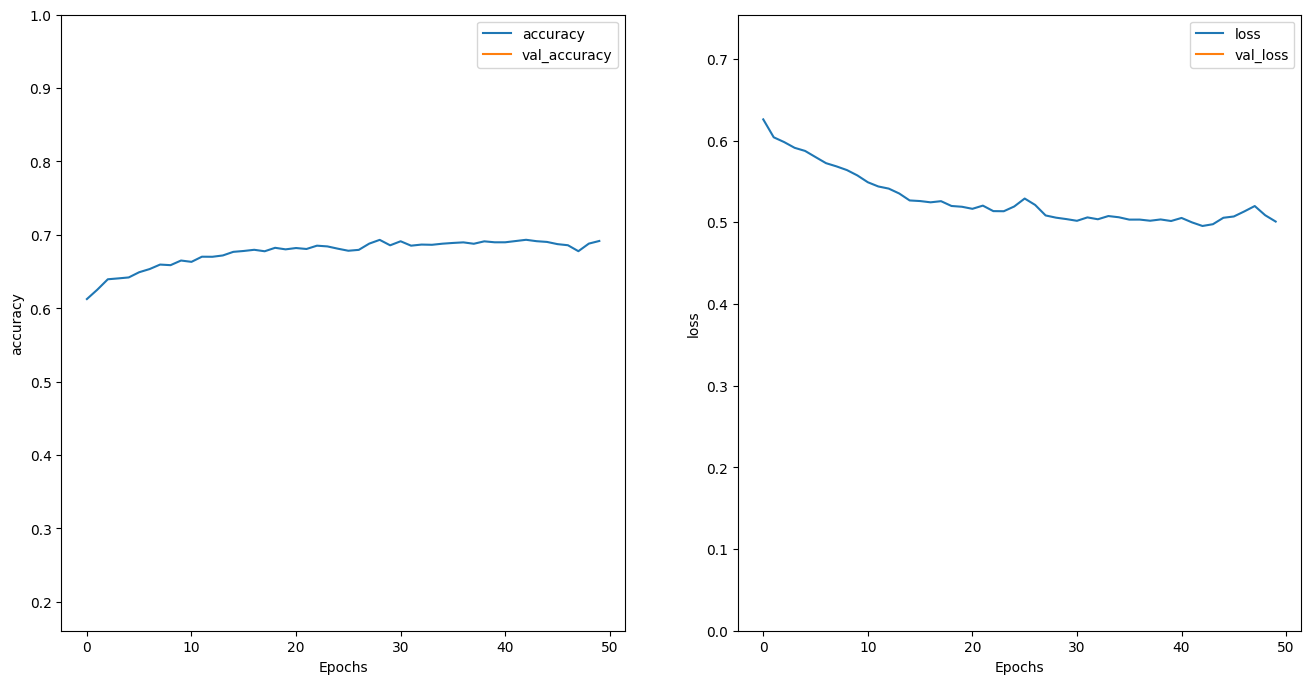

In [80]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [81]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.18928307]


##### Experiment 2: Use binary count vectorizer for encoding

In [82]:
model = create_model(encoder_multi_hot)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.01824062]


In [83]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [84]:
run = wandb.init(project="binary_precalculus_simple", reinit=True)
wandb.config = {
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "multi_hot",
    "tokenizer": "wordpiece"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5501WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221224_013402-1ws7e77f/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221224_013402-1ws7e77f/files/model-best/assets


156/156 [==============================] - 44s 237ms/step - loss: 0.6906 - accuracy: 0.5501 - val_loss: 0.7223 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - 12s 76ms/step - loss: 0.6721 - accuracy: 0.5734
Epoch 3/15
156/156 [==============================] - 10s 67ms/step - loss: 0.6630 - accuracy: 0.5905
Epoch 4/15
156/156 [==============================] - 11s 70ms/step - loss: 0.6628 - accuracy: 0.5910
Epoch 5/15
156/156 [==============================] - 11s 67ms/step - loss: 0.6622 - accuracy: 0.5909
Epoch 6/15
156/156 [==============================] - 10s 66ms/step - loss: 0.6622 - accuracy: 0.5907
Epoch 7/15
156/156 [==============================] - 11s 68ms/step - loss: 0.6622 - accuracy: 0.5915
Epoch 8/15
156/156 [==============================] - 10s 67ms/step - loss: 0.6618 - accuracy: 0.5919
Epoch 9/15
156/156 [==============================] - 10s 62ms/step - loss: 0.6620 - accuracy: 0.5906
Epoch 10/15
156/156 [=========================

In [85]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 0s 22ms/step - loss: 0.7639 - accuracy: 0.1430
Test Loss: 0.7639299035072327
Test Accuracy: 0.14300000667572021


(0.0, 0.7253907144069671)

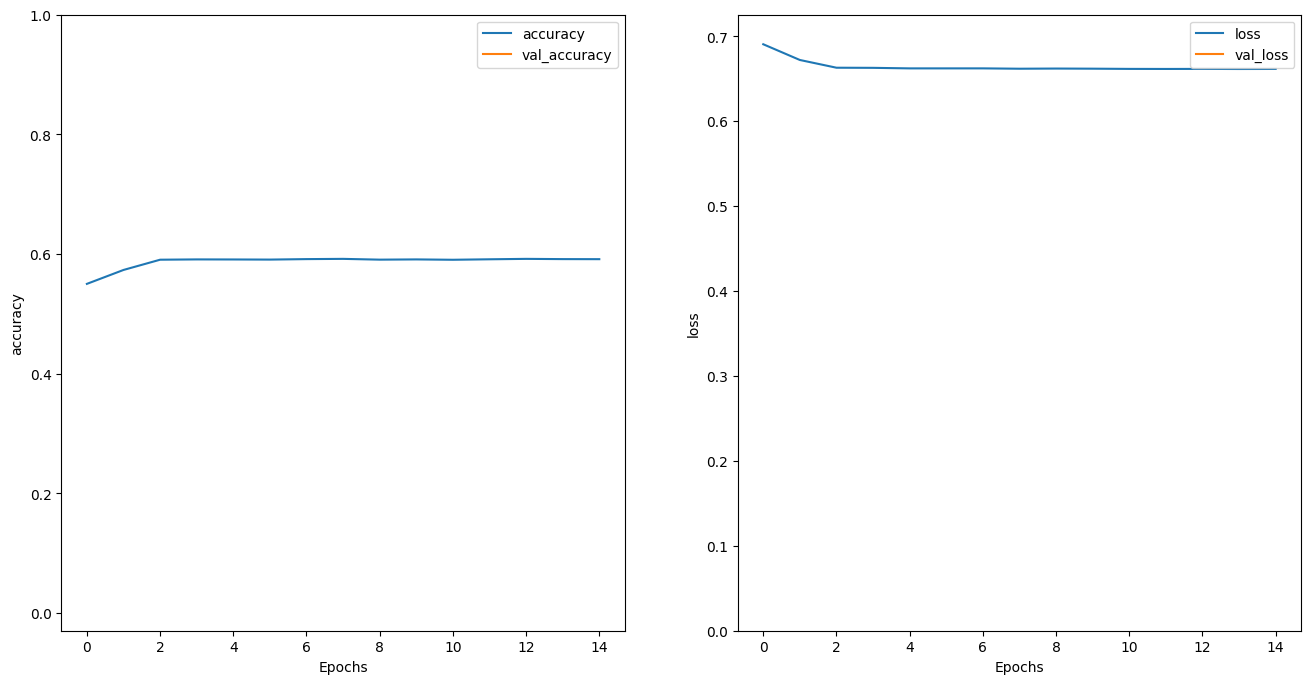

In [86]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [87]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.11082496]


##### Experiment 3:

In [88]:
model = create_model(encoder_count)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.01931924]


In [89]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [90]:
run = wandb.init(project="binary_precalculus_simple", reinit=True)
wandb.config = {
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "count", 
    "tokenizer": "wordpiece"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5501WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221224_013723-12f45fff/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221224_013723-12f45fff/files/model-best/assets


156/156 [==============================] - 45s 234ms/step - loss: 0.6884 - accuracy: 0.5501 - val_loss: 0.7166 - val_accuracy: 0.0010
Epoch 2/15
156/156 [==============================] - 10s 63ms/step - loss: 0.6673 - accuracy: 0.5783
Epoch 3/15
156/156 [==============================] - 10s 62ms/step - loss: 0.6555 - accuracy: 0.5954
Epoch 4/15
156/156 [==============================] - 10s 62ms/step - loss: 0.6543 - accuracy: 0.5970
Epoch 5/15
156/156 [==============================] - 9s 59ms/step - loss: 0.6537 - accuracy: 0.5989
Epoch 6/15
156/156 [==============================] - 10s 63ms/step - loss: 0.6530 - accuracy: 0.5978
Epoch 7/15
156/156 [==============================] - 9s 60ms/step - loss: 0.6529 - accuracy: 0.5981
Epoch 8/15
156/156 [==============================] - 9s 57ms/step - loss: 0.6528 - accuracy: 0.5975
Epoch 9/15
156/156 [==============================] - 9s 61ms/step - loss: 0.6524 - accuracy: 0.5990
Epoch 10/15
156/156 [==============================] -

In [91]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 0s 20ms/step - loss: 0.7596 - accuracy: 0.1410
Test Loss: 0.7596216797828674
Test Accuracy: 0.14100000262260437


(0.0, 0.7199010074138641)

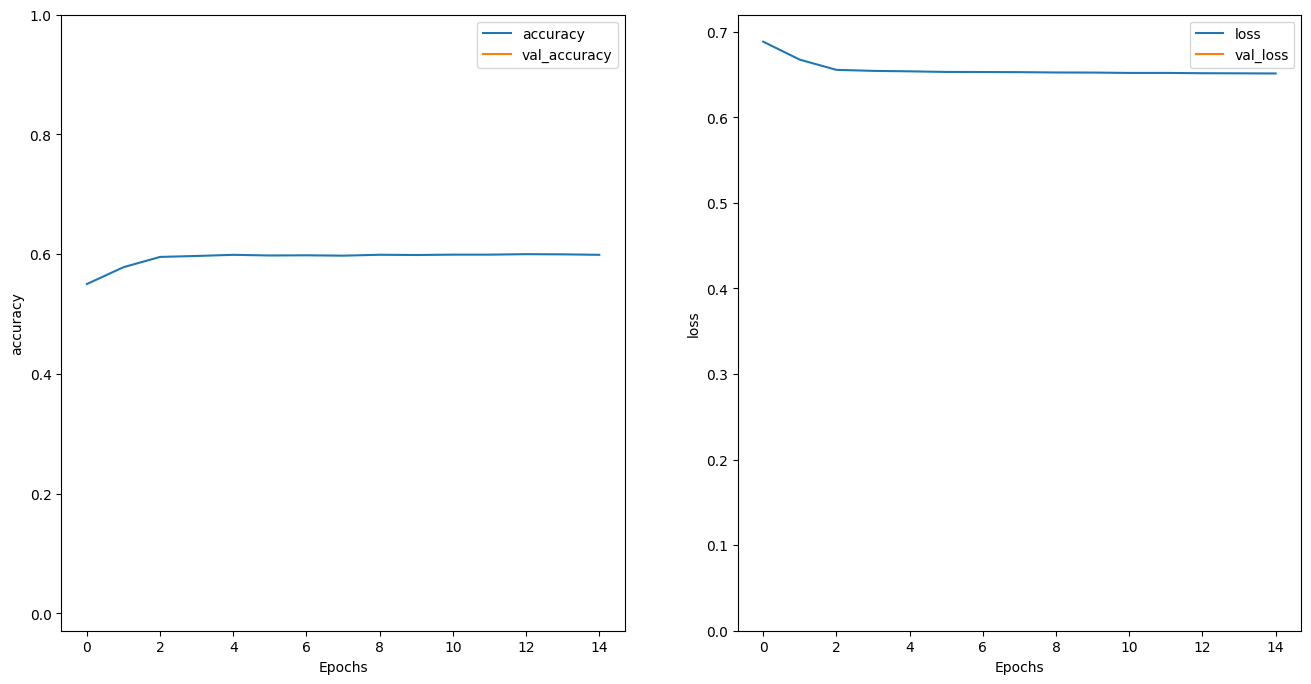

In [92]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [93]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.10056058]


##### Experiment 4:

In [94]:
model = create_model(encoder_bigrams)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.00897886]


In [95]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [ ]:
run = wandb.init(project="binary_precalculus_simple", reinit=True)
wandb.config = {
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "bigram_count",
    "tokenizer": "wordpiece"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [ ]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

##### Experiment 5:

In [ ]:
model = create_model(encoder_tf_idf)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [ ]:
run = wandb.init(project="binary_precalculus_simple", reinit=True)
wandb.config = {
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "tf_idf",
    "tokenizer": "wordpiece"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [ ]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])